## Homework 4

### Подготовка

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
plt.rcParams.update({'font.size': 14})

In [2]:
# сгенерируем данные для задач 1-2
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 5)

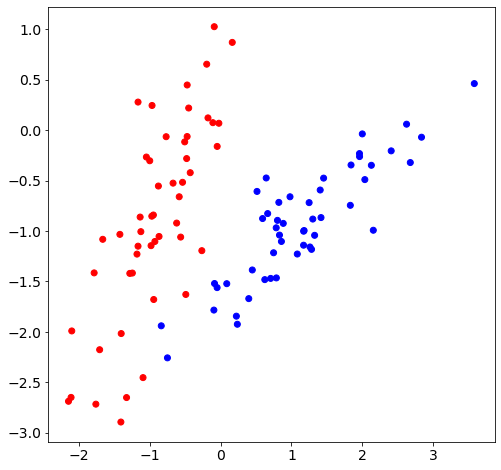

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

### 1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).
### 2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

**Критерий энтропии**

In [7]:
# Расчет критерия энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0:
            impurity = 0
        else:
            impurity = - p * np.log2(p)
        
    return impurity

In [8]:
# Расчет качества в зависимости от критерия

def quality(left_labels, right_labels, current_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if current_criterion[1] == 'gini':
        return current_criterion[0] - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif current_criterion[1] == 'entropy':
        return current_criterion[0] - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        raise TypeError('Choose gini or entropy criterion')

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

**Здесь реализован критерий останова по минимальному числу объектов в листе**

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf=3, criterion='gini'):

    # текущий критерий
    if criterion == 'gini':
        current_criterion = (gini(labels), 'gini')
    elif criterion == 'entropy':
        current_criterion = (entropy(labels), 'entropy')
    else:
        raise TypeError('Choose gini or entropy criterion')

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

**Здесь реализован критерий останова для максимальной глубины дерева и минимального приращения качества**

In [11]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_depth=10, min_samples_leaf=3, min_impurity_decrease=0, criterion='gini', inv=0):

    quality, t, index = find_best_split(data, labels, min_samples_leaf=min_samples_leaf, criterion=criterion)
    # счетчик вызовов функции
    inv += 1

    #  Базовый случай - прекращаем рекурсию, когда прирост в качестве меньше min_impurity_decrease 
    #  или глубина становится равной max_depth (глубина 1 = одноузловое дерево, 2 - с первым уровнем и т.д.)
    if quality <= min_impurity_decrease or inv == max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth=max_depth, inv=inv)
    false_branch = build_tree(false_data, false_labels, max_depth=max_depth, inv=inv)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

**Строим дерево для критерия Джини**

In [15]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, criterion='gini', max_depth=5)

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.09712237000978252
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [19]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [21]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

**Строим дерево для критерия энтропии**

In [22]:
# Построим дерево по обучающей выборке
my_tree2 = build_tree(train_data, train_labels, criterion='entropy', max_depth=5)

In [23]:
print_tree(my_tree2)

Индекс 0
Порог 0.663389024866191
--> True:
  Индекс 0
  Порог -0.11161924805848533
  --> True:
    Индекс 1
    Порог -1.9402933258134305
    --> True:
      Индекс 0
      Порог -1.4121643353903564
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 1
    Порог -0.47459868073545697
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 1


#### Получились разные пороги

In [24]:
# Получим ответы для обучающей выборки 
train_answers2 = predict(train_data, my_tree2)

In [25]:
# И получим ответы для тестовой выборки
answers2 = predict(test_data, my_tree2)

In [26]:
# Точность на обучающей выборке
train_accuracy2 = accuracy_metric(train_labels, train_answers2)
train_accuracy2

98.57142857142858

**Точность на обучающей выборке идентична**

In [27]:
# Точность на тестовой выборке
test_accuracy2 = accuracy_metric(test_labels, answers2)
test_accuracy2

96.66666666666667

**Точность на тестовой выборке ниже, чем для критерия Джини**

<ipython-input-30-fc0e5637b4a8>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-30-fc0e5637b4a8>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-30-fc0e5637b4a8>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corne

Text(0.5, 1.0, 'Entropy criterion. Test accuracy=96.67')

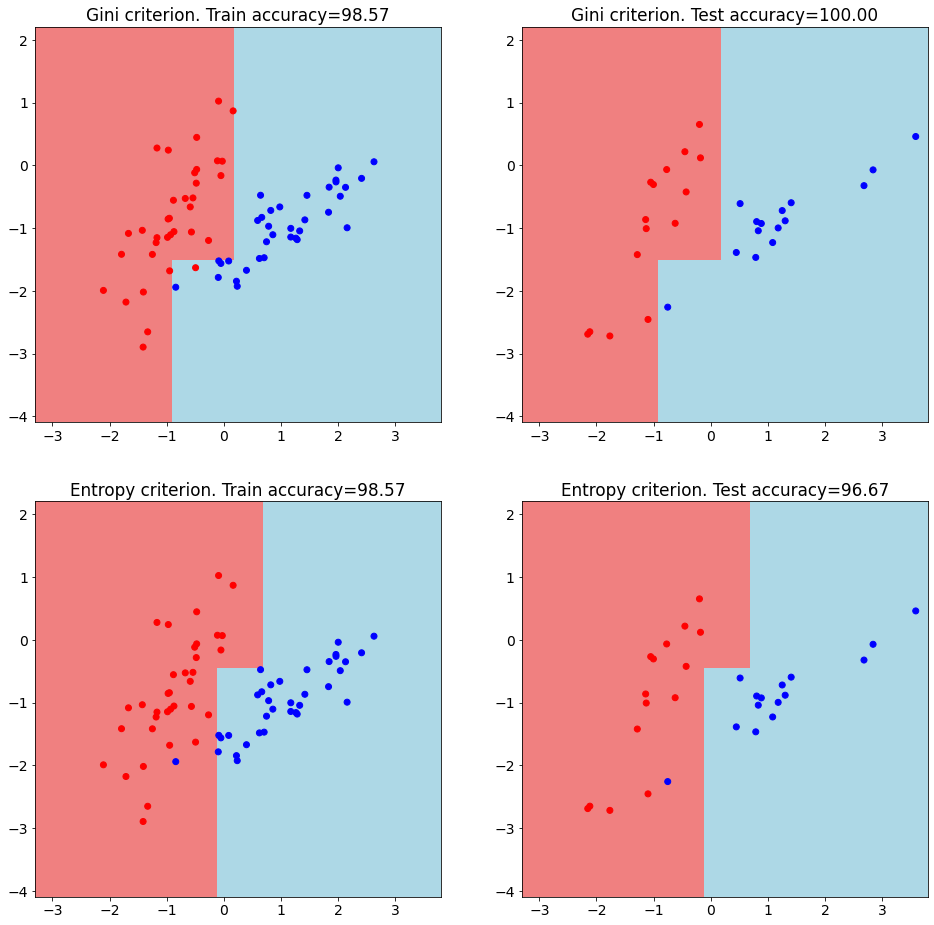

In [30]:
# Визуализируем дерево с критериями на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 16))

# график обучающей выборки Джини
plt.subplot(2,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Gini criterion. Train accuracy={train_accuracy:.2f}')

# график тестовой выборки Джини 
plt.subplot(2,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Gini criterion. Test accuracy={test_accuracy:.2f}')

# график обучающей выборки энтропия
plt.subplot(2,2,3)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Entropy criterion. Train accuracy={train_accuracy2:.2f}')

# график тестовой выборки энтропия
plt.subplot(2,2,4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Entropy criterion. Test accuracy={test_accuracy2:.2f}')

### Проверим работу моделей на аналогах из библиотеки sklearn

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
# Для критерия Джини
classifier_gini = RandomForestClassifier(n_estimators=1, criterion='gini', max_depth=5, min_samples_leaf=3, bootstrap=False)
classifier_gini.fit(train_data, train_labels)
classifier_gini_pred = classifier_gini.predict(test_data)
accuracy_metric(test_labels, classifier_gini_pred)

100.0

In [57]:
classifier_gini_pred == answers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Результат идентичен

In [59]:
# Для критерия энтропии
classifier_entropy = RandomForestClassifier(n_estimators=1, criterion='entropy', max_depth=5, min_samples_leaf=3, bootstrap=False)
classifier_entropy.fit(train_data, train_labels)
classifier_entropy_pred = classifier_entropy.predict(test_data)
accuracy_metric(test_labels, classifier_entropy_pred)

96.66666666666667

In [60]:
classifier_entropy_pred == answers2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Результат также идентичен